In [1]:
%load_ext autoreload
%autoreload 2
import csv
import os

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

In [2]:
from PRISM.config import get_model_config
from PRISM.data import DataManager
from PRISM.model import GeneGNN
from PRISM.train import predict, train_and_validate
from PRISM.utils import calculate_metrics, fetch_drug_name
from PRISM.visualize import (plot_gene_interaction_network,
                             plot_training_curves, visualize_top_nodes_wrapper)

# PRISM Tutorial

This tutorial introduces the use of PRISM, a tool designed for predicting drug response prediction and visualizing gene interaction networks in response to specific treatments. The notebook is structured to guide you through the process of loading and preparing data, prediction, analyzing gene interactions, and visualizing these interactions to infer biological significance.

## Get config

In [3]:
config = get_model_config("GT")
config

{'USE_DATA_TYPES': ['exp', 'met', 'cop', 'mut'], 'NUM_SAMPLES': 5, 'GENE_FEATURE_DIMENSION': 4, 'GENE_EDGE_DIMENSION': 7, 'NUM_GENES': 5181, 'DROPOUT_RATE': 0.1, 'HIDDEN_CHANNEL_SIZE': 32, 'LEARNING_RATE': 0.001, 'MSE_WEIGHT': 1.1, 'NUM_ATTENTION_HEADS': 1, 'NUM_EPOCHS': 2, 'NUM_GNN_LAYERS': 3, 'USE_TRANSFORMER': True, 'OUTPUT_CHANNEL_SIZE': 1, 'BATCH_SIZE': 70, 'IMPORTANCE_DECAY': 0.8, 'IMPORTANCE_REGULARIZATION_WEIGHT': 0.02, 'IMPORTANCE_THRESHOLD': 0.001}


{'USE_DATA_TYPES': ['exp', 'met', 'cop', 'mut'],
 'NUM_SAMPLES': 5,
 'GENE_FEATURE_DIMENSION': 4,
 'GENE_EDGE_DIMENSION': 7,
 'NUM_GENES': 5181,
 'DROPOUT_RATE': 0.1,
 'HIDDEN_CHANNEL_SIZE': 32,
 'LEARNING_RATE': 0.001,
 'MSE_WEIGHT': 1.1,
 'NUM_ATTENTION_HEADS': 1,
 'NUM_EPOCHS': 2,
 'NUM_GNN_LAYERS': 3,
 'USE_TRANSFORMER': True,
 'OUTPUT_CHANNEL_SIZE': 1,
 'BATCH_SIZE': 70,
 'IMPORTANCE_DECAY': 0.8,
 'IMPORTANCE_REGULARIZATION_WEIGHT': 0.02,
 'IMPORTANCE_THRESHOLD': 0.001}

In [4]:
config["BATCH_SIZE"] = 2

## Data Preprocessing

In [5]:
data_manager = DataManager(config)
data_manager.load_and_process_data()
data_manager.create_data_loaders()

Starting data loading and processing...
Train data size: 5
Creating train data...


Creating gene data list: 100%|██████████████████████| 5/5 [00:00<00:00, 3402.81it/s]


Train data created.
Valid data size: 5
Creating valid data...


Creating gene data list: 100%|██████████████████████| 5/5 [00:00<00:00, 4393.78it/s]


Valid data created.
Test data size: 5
Creating test data...


Creating gene data list: 100%|██████████████████████| 5/5 [00:00<00:00, 3990.77it/s]


Test data created.
Data loading and processing completed.
Starting creation of data loaders...
Creation of data loaders completed.


## Prediction

In [6]:
state_dict = torch.load(
    "result/best_model_GT.pth", map_location=torch.device("cpu"), weights_only=True
)
model = GeneGNN(config)
model.load_state_dict(state_dict)
model.eval()

print("Generating predictions and evaluating the model...")
# Generate predictions and other relevant metrics from the model.
results, test_preds, y_test, importances = predict(
    model, data_manager, save_results=True
)

Generating predictions and evaluating the model...


Predicting: 100%|█████████████████████████████████████| 2/2 [00:06<00:00,  3.26s/it]


Only one class in targets. Cannot calculate AUC-ROC and AUC-PR.


/Users/yoshitakainoue/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoshitakainoue/miniconda3/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
res = calculate_metrics(y_test, test_preds)
res

{'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1': 1.0,
 'f2': 1.0,
 'AUC-ROC': None,
 'AUC-PR': None,
 'Specificity': 0.0,
 'NPV': 0.0}

## Read importances

In [9]:
res = pd.read_csv("result/importance.csv.gz")
res

,nsc,cell_name,type,A2M,AAAS,AACS,AAK1,AAR2,AARS2,AASDH,...,ZNF746,ZNF789,ZNF804B,ZNF84,ZNF93,ZRANB1,ZRANB3,ZWILCH,ZWINT,ZYX
0,767354,SK_MEL_2,Test,0.000000,0.000000,0.000000,0.000000,0.001928,0.000000,0.001065,...,0.002429,0.001220,0.001000,0.000000,0.001054,0.001103,0.001079,0.001093,0.000000,0.001620
1,800108,HOP_62,Test,0.000000,0.000000,0.000000,0.000000,0.001585,0.000000,0.001814,...,0.002001,0.001571,0.001290,0.000000,0.001255,0.001851,0.000000,0.002708,0.004961,0.002801
2,800937,OVCAR_5,Test,0.917318,0.918831,0.003581,0.000000,0.001825,0.001615,0.000000,...,0.000000,0.921542,0.002301,0.000000,0.918234,0.000000,0.918125,0.917987,0.918739,0.000000
3,654830,OVCAR_5,Test,0.000000,0.000000,0.000000,0.000000,0.001612,0.000000,0.001156,...,0.002450,0.001049,0.001337,0.000000,0.000965,0.003375,0.000000,0.001027,0.001370,0.002220
4,800812,BT_549,Test,0.000000,0.000000,0.000000,0.000000,0.001611,0.001032,0.000000,...,0.000745,0.001423,0.001266,0.000000,0.000739,0.000000,0.000000,0.000000,0.000000,0.001959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6537,767348,OVCAR_4,Val,0.124565,0.074852,0.085241,0.084553,0.085170,0.086026,0.090084,...,0.118863,0.081091,0.088529,0.061197,0.070111,0.119214,0.065762,0.081829,0.075016,0.129073
6538,767354,SK_MEL_2,Test,0.000000,0.000000,0.000000,0.000000,0.001928,0.000000,0.001065,...,0.002429,0.001220,0.001000,0.000000,0.001054,0.001103,0.001079,0.001093,0.000000,0.001620
6539,800108,HOP_62,Test,0.000000,0.000000,0.000000,0.000000,0.001585,0.000000,0.001814,...,0.002001,0.001571,0.001290,0.000000,0.001255,0.001851,0.000000,0.002708,0.004961,0.002801
6540,800937,OVCAR_5,Test,0.917318,0.918831,0.003581,0.000000,0.001825,0.001615,0.000000,...,0.000000,0.921542,0.002301,0.000000,0.918234,0.000000,0.918125,0.917987,0.918739,0.000000


In [10]:
name = [fetch_drug_name(i) for i in (res.nsc)]
res.insert(3, "name", name)

In [11]:
edge_index = torch.load("data/edge_index.pt", weights_only=False)

# Visualization with DTI and importance information

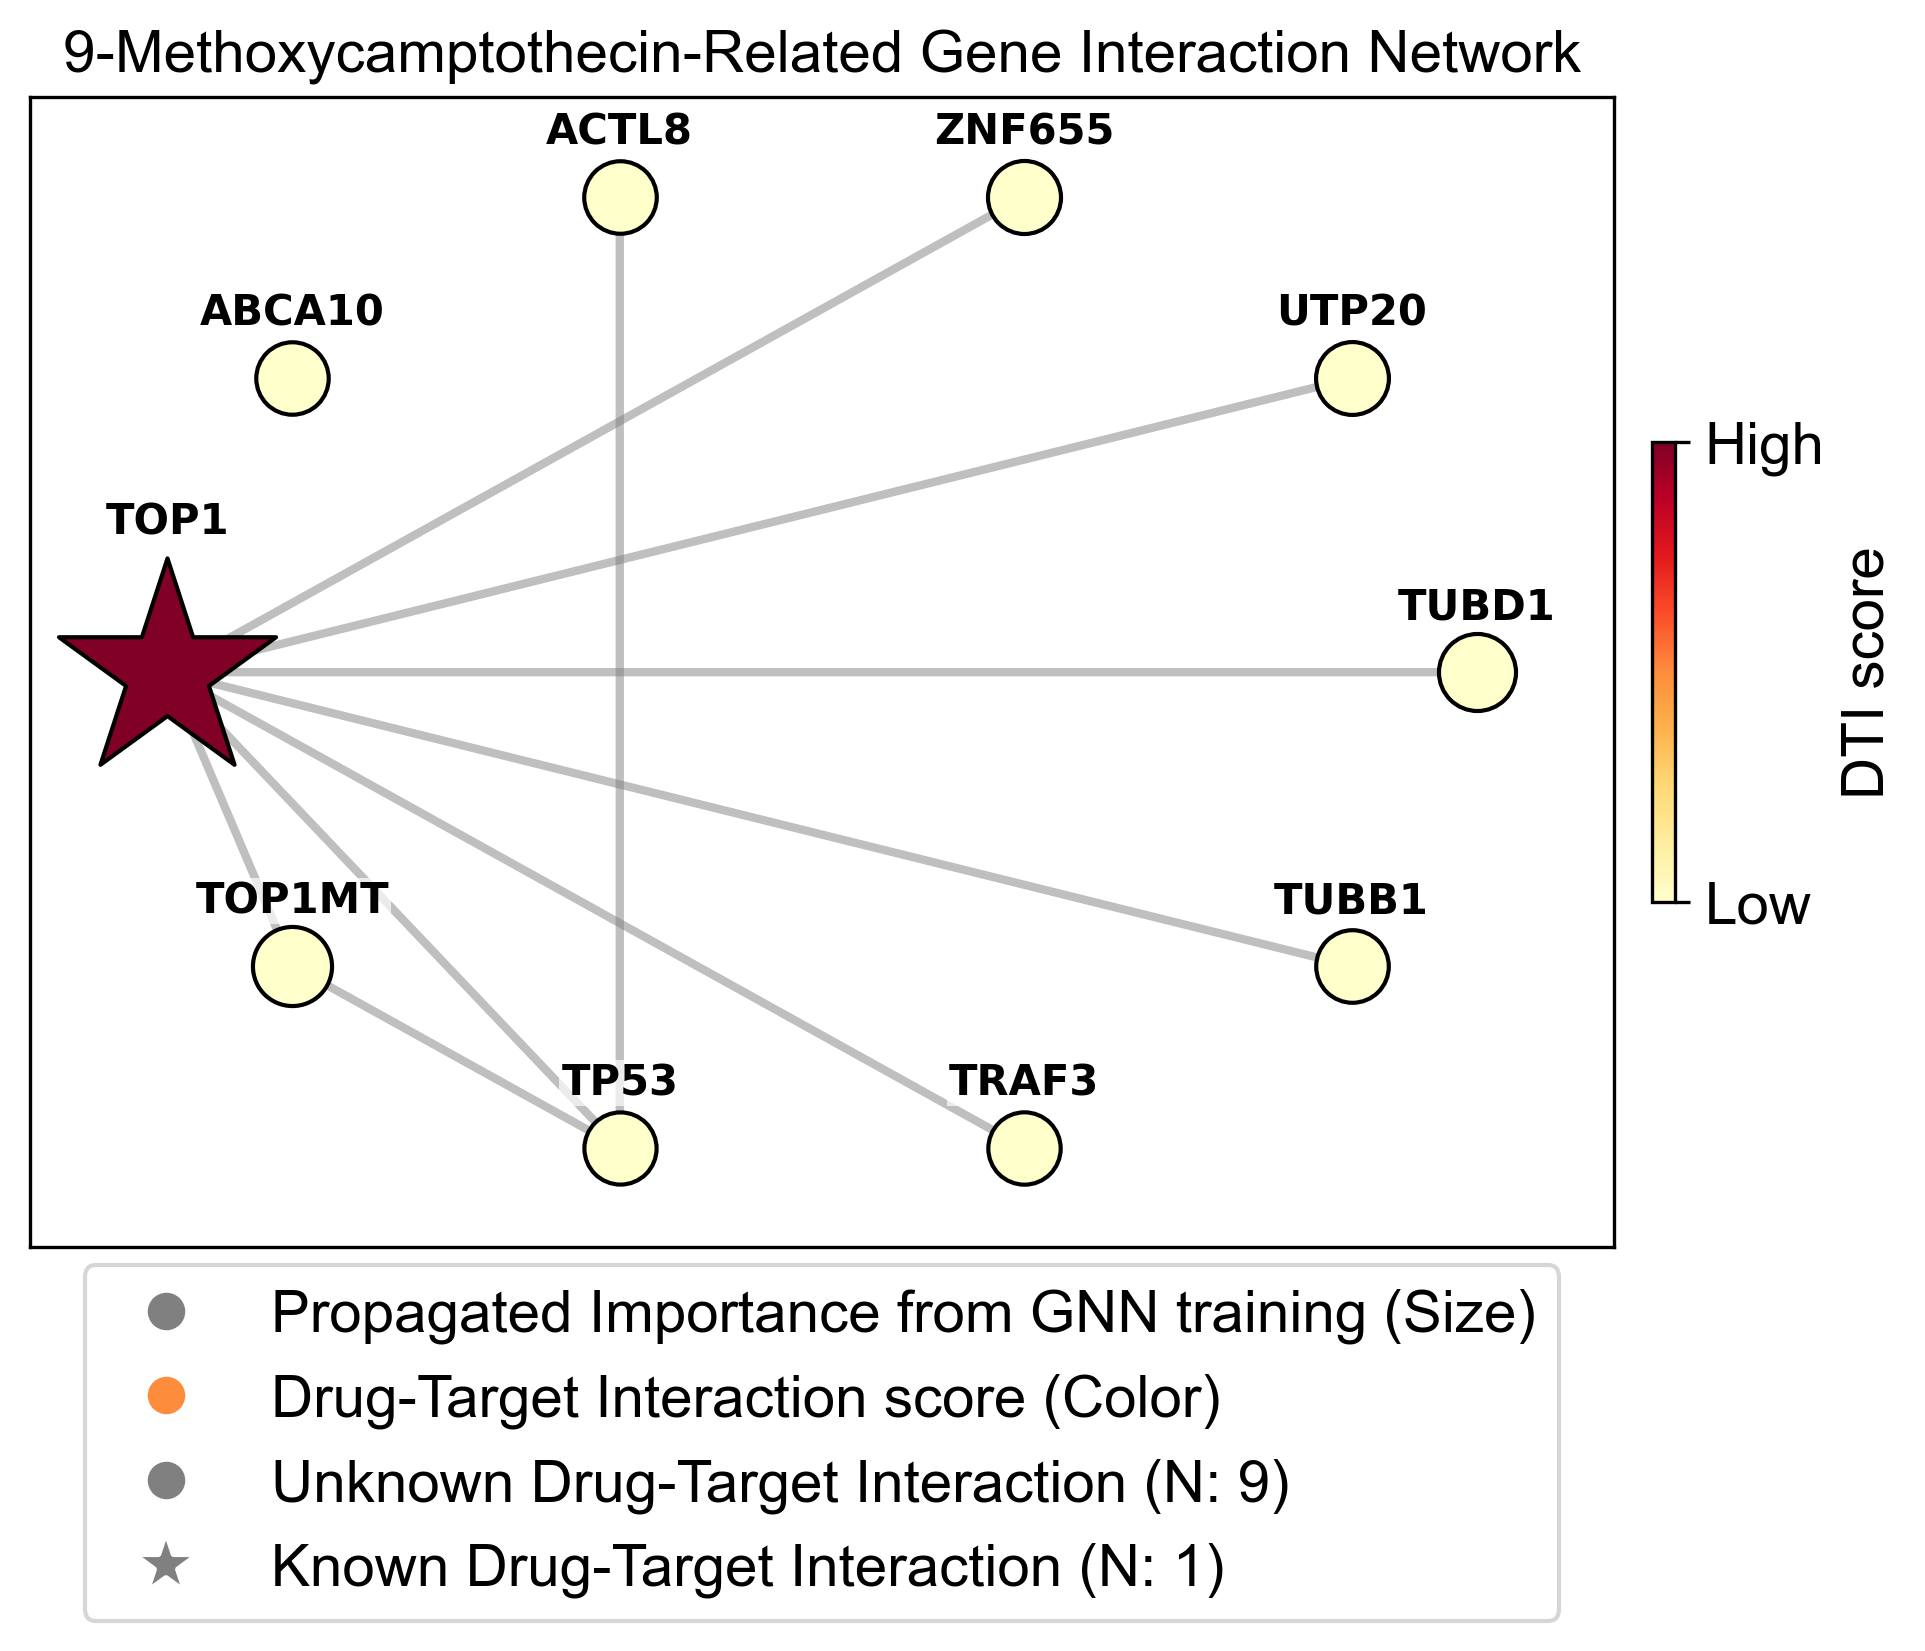

In [12]:
plot_gene_interaction_network(
    drug="9-Methoxycamptothecin",
    N=10,
    res=res,
    layout="shell",
    font_size=14,
    bbox_to_anchor=(0.5, -0.35),
    figsize=(7, 6),
)